In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 12

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

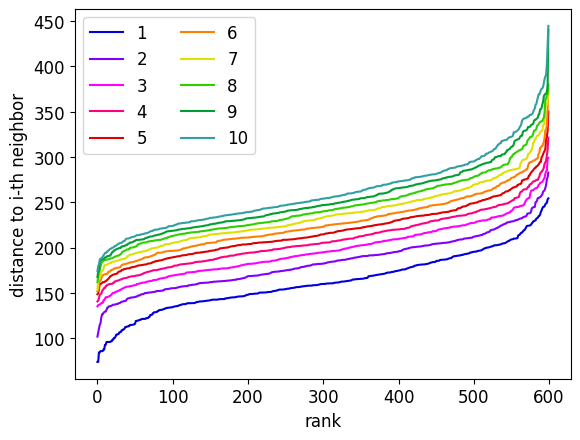

mean minimum distance between points:  162.34622464324366


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)

## t-SNE visualization, for true labels

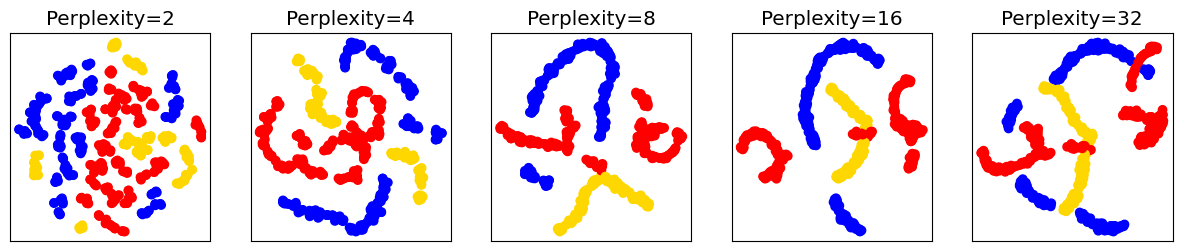

In [4]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

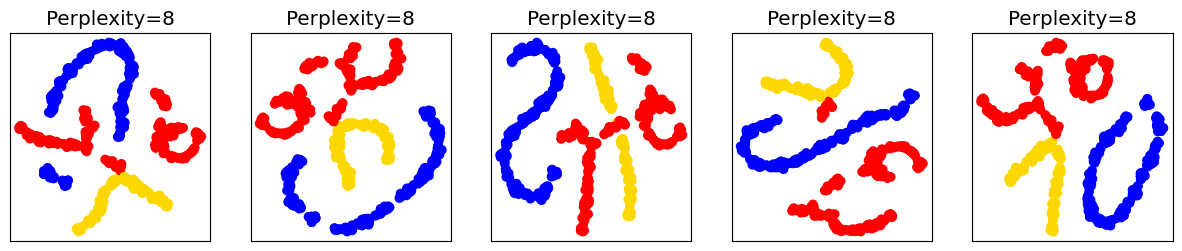

In [5]:
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',random_state=i, 
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

In [6]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46",
            "#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF",
            "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C",
            "#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81",
            "#575329", "#00FECF", "#B05B6F"]


def clustering(y):
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    h = 0.
    for kc in c.keys():
        p = len(c[kc]) / n_sample
        h += p * np.log(p)
    h *= -1.
    return h

def NMI(y_true, y_pred):
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c = len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c * np.log(n_sample * w_intersect_c / (len(w[kw]) * len(c[kc])))
    Iwc /= n_sample
    Hc = entropy(c, n_sample)
    Hw = entropy(w, n_sample)
    
    return 2 * Iwc / (Hc + Hw)

# Imposta il seed per la riproducibilità e definisci il dataset (assumendo che X_all, data, y, mean_min_dist ecc. siano già definiti)
np.random.seed(12345)
n_true_center = 3

X2D = X_all[2]  # Visualizzazione 2D
X = data
y_true = y

# Definiamo gli intervalli per ε (10 a 300 a passi di 10) e min_samples (1 a 50 a passi di 1)
eps_range = np.arange(10, 301, 10)
min_sample_range = np.arange(1, 51, 1)

DIMY = len(eps_range)
DIMX = len(min_sample_range)

# Inizializza la matrice per salvare i valori NMI
nmi_matrix = np.zeros((DIMY, DIMX))

# Loop sui valori di ε e mP
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi_value = NMI(y_hat, y_true)
        nmi_matrix[i, j] = nmi_value




# Correlation between ε (epsilon) and mP (min_samples)

In clustering, we use two parameters: **ε (epsilon)**, which controls the radius of the neighborhood, and **mP (min_samples)**, which defines the minimum number of points required to form a cluster. The **Normalized Mutual Information (NMI)** is used to measure how well the clustering algorithm (like DBSCAN) matches the true cluster labels.

## What is NMI?

**NMI** is a measure of the similarity between two clusterings, the true clustering and the predicted clustering. It ranges from 0 to 1:
- **0** means no similarity between the clusterings.
- **1** means perfect similarity between the clusterings.

The formula for NMI is:

$$
\text{NMI}(A, B) = \frac{2 \, I(A, B)}{H(A) + H(B)}
$$

where:
- \(I(A, B)\) is the **Mutual Information** between the true and predicted clusters.
- \(H(A)\) and \(H(B)\) are the **Entropy** of the true and predicted clusters, respectively.

## Correlation Between ε and mP

In our analysis, we look at how the NMI changes with different values of **ε** and **mP**. If the high NMI values appear in specific regions of the heatmap (where **ε** and **mP** have certain values), this indicates a **correlation** between **ε** and **mP** in achieving better clustering. For example:
- If high NMI values appear when both **ε** and **mP** are large, it suggests that a larger **ε** and **mP** lead to better clustering results.
- If high NMI values appear when both are small, then smaller values of both parameters are better.

### Conclusion

By observing the heatmap, we can tell if there's a correlation between **ε** and **mP** and how these parameters affect the clustering performance.


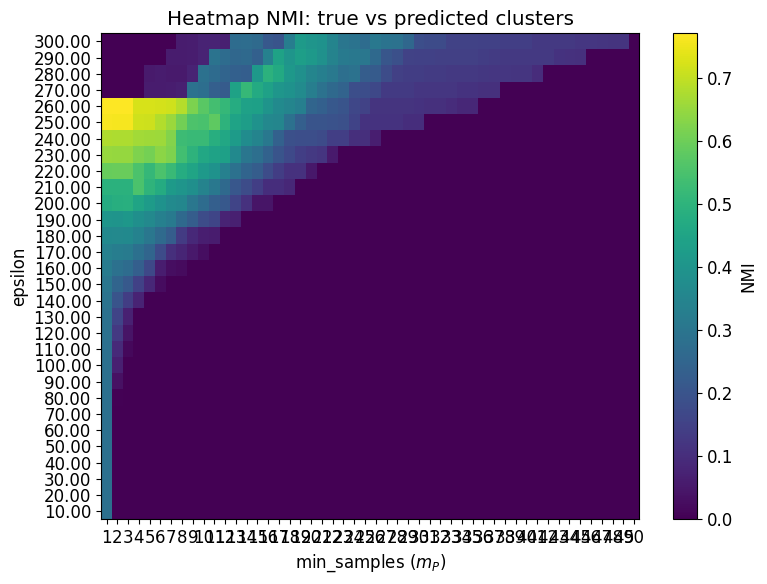

In [7]:
# Creazione della heatmap per visualizzare NMI in funzione di ε e mP
plt.figure(figsize=(8, 6))
# Visualizza la heatmap; origin='lower' per far corrispondere l'asse y all'ordine crescente di eps_range
im = plt.imshow(nmi_matrix, origin='lower', aspect='auto', cmap='viridis')

# Aggiungi la barra dei colori
cbar = plt.colorbar(im)
cbar.set_label('NMI')

# Imposta le etichette degli assi
plt.xlabel('min_samples ($m_P$)')
plt.ylabel('epsilon')

# Imposta i tick corrispondenti alle posizioni centrali delle celle
plt.xticks(np.arange(DIMX), min_sample_range)
plt.yticks(np.arange(DIMY), ["%.2f" % eps for eps in eps_range])

plt.title('Heatmap NMI: true vs predicted clusters')
plt.tight_layout()
plt.show()


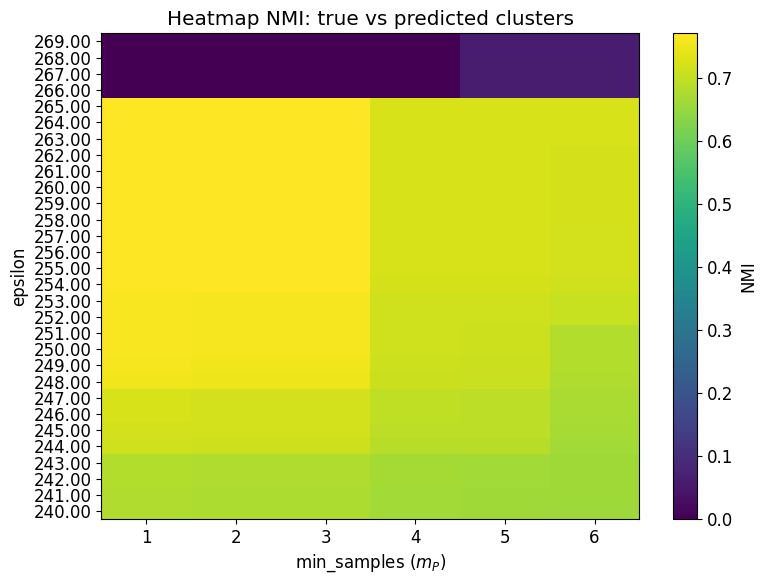

In [8]:
# Loop sui valori di ε e mP
eps_range = np.arange(240, 270, 1)
min_sample_range = np.arange(1, 7, 1)


DIMY = len(eps_range)
DIMX = len(min_sample_range)

# Inizializza la matrice per salvare i valori NMI
nmi_matrix = np.zeros((DIMY, DIMX))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi_value = NMI(y_hat, y_true)
        nmi_matrix[i, j] = nmi_value

# Creazione della heatmap per visualizzare NMI in funzione di ε e mP
plt.figure(figsize=(8, 6))
# Visualizza la heatmap; origin='lower' per far corrispondere l'asse y all'ordine crescente di eps_range
im = plt.imshow(nmi_matrix, origin='lower', aspect='auto', cmap='viridis')

# Aggiungi la barra dei colori
cbar = plt.colorbar(im)
cbar.set_label('NMI')

# Imposta le etichette degli assi
plt.xlabel('min_samples ($m_P$)')
plt.ylabel('epsilon')

# Imposta i tick corrispondenti alle posizioni centrali delle celle
plt.xticks(np.arange(DIMX), min_sample_range)
plt.yticks(np.arange(DIMY), ["%.2f" % eps for eps in eps_range])

plt.title('Heatmap NMI: true vs predicted clusters')
plt.tight_layout()
plt.show()


### Since DB- Clustering is an invasive algorithm we can see that above epsilon = 265 the NMI drops drastically to 0, meaning that in this case this is the threshold for dividing two or more clusters, with the refined comparison we perform another DB-clustering and see the different results.
### As we can see from below, the DB Clustering algorithm is not able to correctly identify the 3 clusters separately, we can also see this from the heatmap since we don't obtain a value higher that roughly 0.7

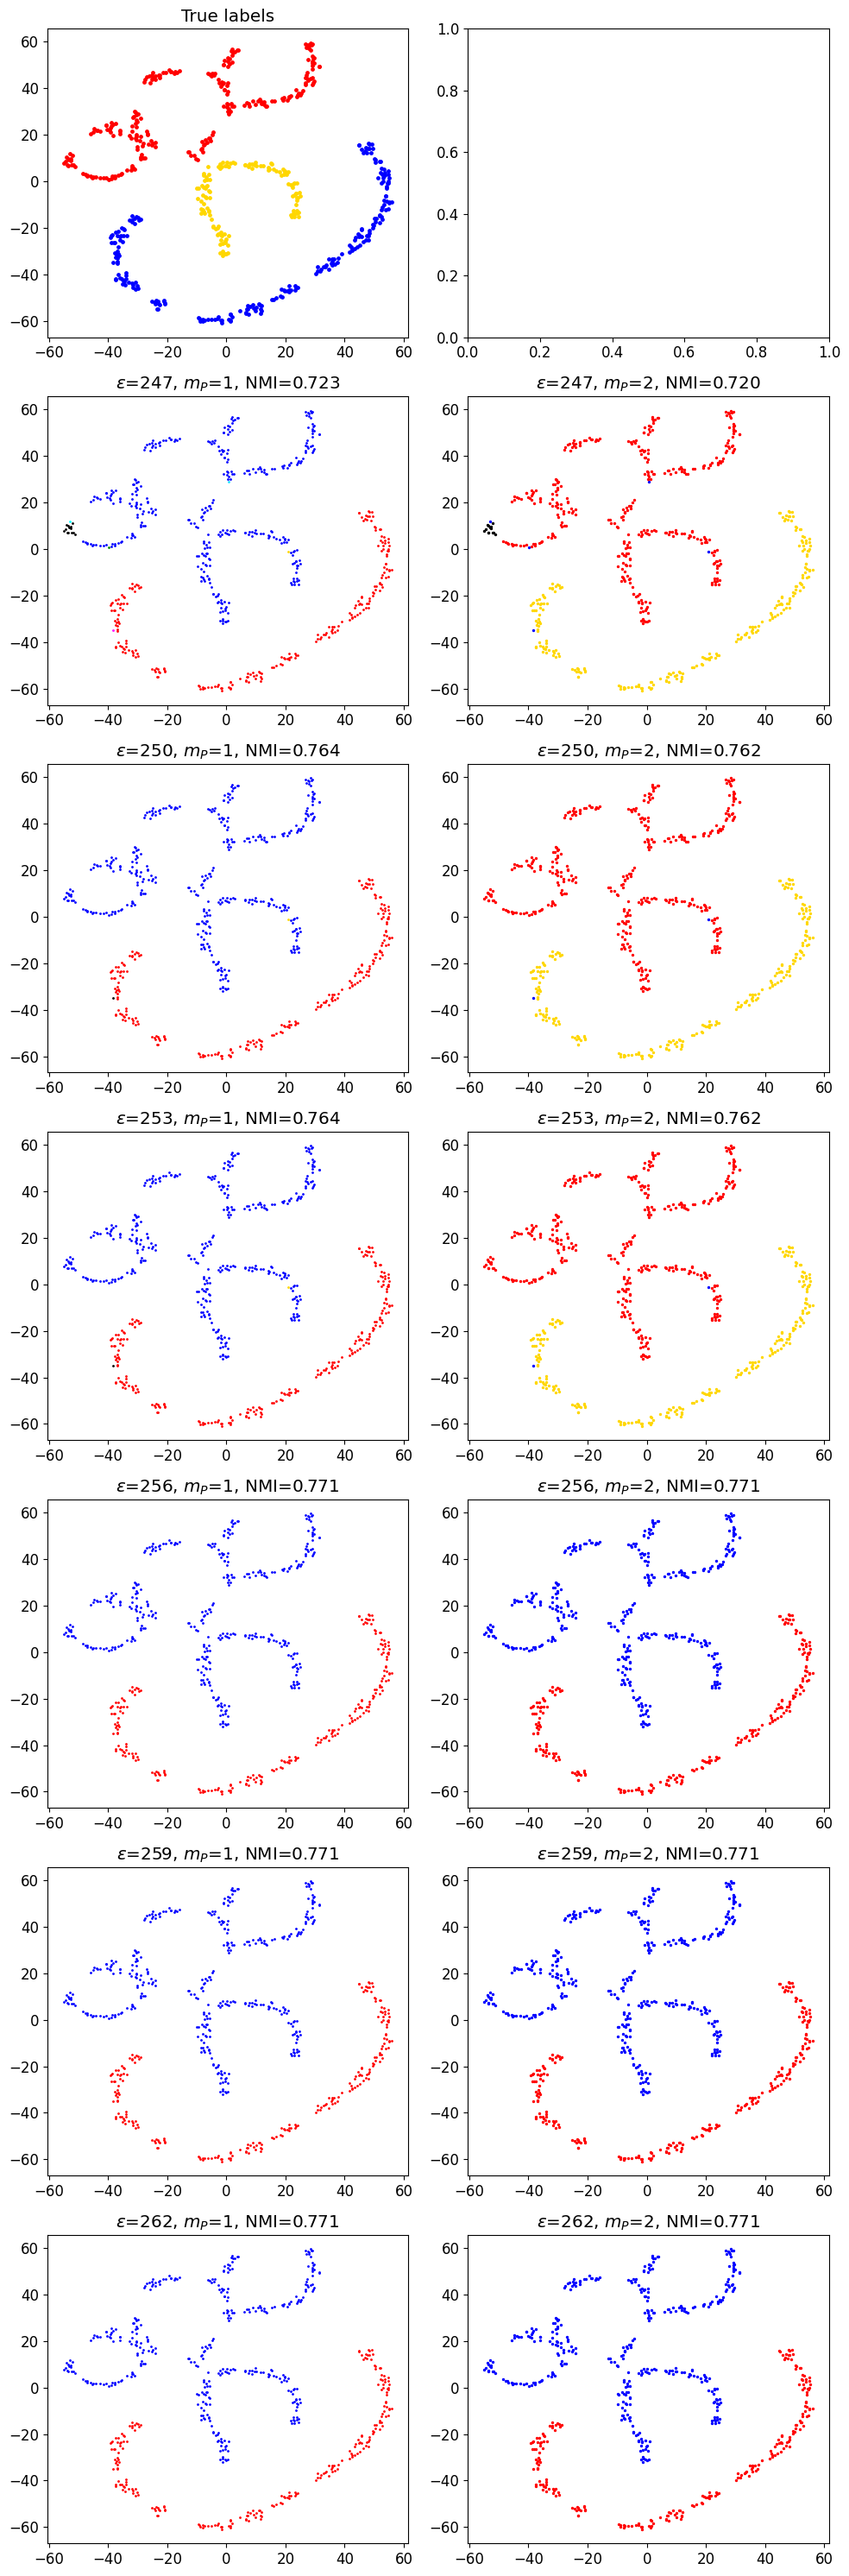

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

cpalette = ["blue", "red", "gold", "black", "magenta", "green", "cyan", "#1CE6FF", "#FF34FF", "#FF4A46",
            "#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
            "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#886F4C", "#34362D", "#B4A8BD",
            "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81", "#575329", "#00FECF", "#B05B6F"]
ms = 6

def plotting_ax(X, y, ax):
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos, 0], X[pos, 1], c=cpalette[i % len(cpalette)], s=6)

def plotting_axs(X, y, ax, ms):
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos, 0], X[pos, 1], c=cpalette[i % len(cpalette)], s=ms)

# Definiamo gli intervalli per ε (10 a 300 a passi di 10) e min_samples (1 a 50 a passi di 1)
eps_range = np.arange(247, 265, 3)
min_sample_range = np.arange(1, 3, 1)

DIMY = len(eps_range)
DIMX = len(min_sample_range)

# Inizializza la matrice per salvare i valori NMI
nmi_matrix = np.zeros((DIMY, DIMX))

# Prepara una griglia per visualizzare i clustering ottenuti e salva i valori NMI
# Modifica il figsize per fare spazio sufficiente per almeno 4 plot per riga
fig, ax = plt.subplots(DIMY + 1, DIMX, figsize=(10, 30))  # Adjusted figsize for more plots per row

# Plot dei dati con le etichette vere (prima riga)
plotting_ax(X2D, y, ax[0, 0])
ax[0, 0].set_title('True labels')

# Inizializza la matrice per salvare i valori NMI
nmi_matrix = np.zeros((DIMY, DIMX))

# Loop sui valori di ε e mP
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_axs(X2D, y_hat, ax[i + 1, j], ms=min_samples)
        nmi_value = NMI(y_hat, y_true)
        nmi_matrix[i, j] = nmi_value
        ax[i + 1, j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f' % (eps, min_samples, nmi_value))

# Adjust the layout to avoid overlap of titles and labels
plt.tight_layout(h_pad=1.0)
plt.show()


# Relation Between Optimal ε and the mP-th Ranked Distances in DBSCAN

The optimal **ε** corresponds to the distance where a clear separation between clusters and noise can be made. This can be visualized by plotting the ranked distances to the **mP-th** neighbor for all points and identifying the "elbow" point, which marks a significant increase in the distance. This elbow point typically represents the optimal **ε** value.

The **mP-th distance** is the distance to the **mP-th closest neighbor**.
The plot the **mP-th** neighbor's distances will often show a sharp increase, indicating a transition from dense regions to sparser regions (noise).
The **optimal ε** is typically the value where the plot shows a sharp increase or "elbow," marking the threshold where points start to become distant from each other.


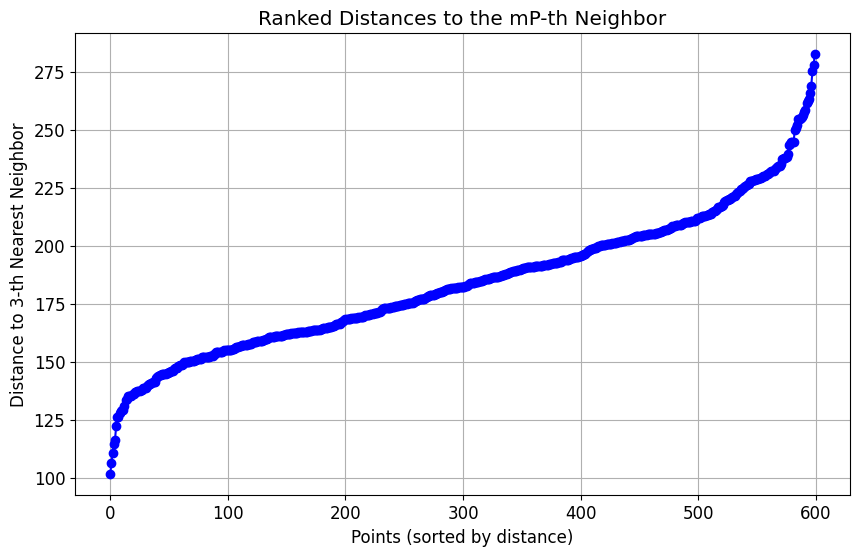

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Assuming X is your data

mP = 3  # min_samples
# Find nearest neighbors for each point in the dataset
neighbors = NearestNeighbors(n_neighbors=mP)
neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# distances[:, -1] gives the distance to the mP-th neighbor
mP_distances = distances[:, -1]

# Sort the mP-th distances in ascending order
sorted_distances = np.sort(mP_distances)

# Plot the ranked distances to the mP-th neighbor
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances, marker='o', linestyle='-', color='b')
plt.title('Ranked Distances to the mP-th Neighbor')
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'Distance to {mP}-th Nearest Neighbor')
plt.grid(True)
plt.show()
